In [26]:
import json

from pathlib import Path

import pandas as pd
import numpy as np

import biopsykit as bp


from biopsykit.classification.model_selection import SklearnPipelinePermuter
import pepbench.plotting
from pepbench.io import load_best_performing_algos, load_preprocessed_training_data, compute_abs_error

import matplotlib.pyplot as plt

%matplotlib widget
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
model_path = Path("../../results/models")
data_path = Path("../../results/data")
result_path = Path("../../results")

### Permuter 1: Scaling, Feature Elimination, NearestNeighbor, DecisionTree

In [24]:
permuter1 = SklearnPipelinePermuter.from_pickle(model_path.joinpath("KNeighbors.pkl"))
permuter1.metric_summary()

true_labels  ... test_neg_mean_absolute_error_fold_4
pipeline_scaler pipeline_reduce_dim pipeline_clf                                                            ...                                    
StandardScaler  SelectKBest         KNeighborsRegressor  [370.0, 346.0, 374.0, 316.0, 336.0, 322.0, 334...  ...                           10.172664
                RFE                 KNeighborsRegressor  [370.0, 346.0, 374.0, 316.0, 336.0, 322.0, 334...  ...                            8.634332
MinMaxScaler    SelectKBest         KNeighborsRegressor  [370.0, 346.0, 374.0, 316.0, 336.0, 322.0, 334...  ...                           10.266268
                RFE                 KNeighborsRegressor  [370.0, 346.0, 374.0, 316.0, 336.0, 322.0, 334...  ...                            9.764100

[4 rows x 15 columns]

In [54]:
permuter1.best_hyperparameter_pipeline()

mean_test_neg_mean_absolute_error  ...  std_test_neg_mean_absolute_error
outer_fold                                     ...                                  
0                                   -8.746015  ...                          0.797350
1                                   -9.186139  ...                          0.673533
2                                   -9.063227  ...                          0.448772
3                                   -9.528919  ...                          0.486320
4                                   -9.014135  ...                          1.215029

[5 rows x 14 columns]

In [ ]:
reference_labels = permuter1.metric_summary()["true_labels"].loc[("StandardScaler", "RFE", "KNeighborsRegressor")]
reference_labels

array([370., 346., 374., ..., 180., 207., 211.])

#### Compute the absolute errors of the algo outputs

In [15]:
abs_error_estimator = np.abs(permuter1.metric_summary()["predicted_labels"].loc[("StandardScaler", "RFE", "KNeighborsRegressor")] - reference_labels)
abs_error_estimator

array([ 9.21760988, 10.59513319,  2.55468625, ..., 17.59734523,
        8.70272322, 17.65995012])

In [9]:
np.mean(abs_error_estimator)

9.265040566679726

### Load the computed labels of algorithms that showed good performance

In [46]:
best_algos_empkins = load_best_performing_algos(result_path.joinpath("empkins_dataset_reference_q_wave").resolve(), n_best=2)
best_algos_empkins

mean       std
b_point_algorithm outlier_correction_algorithm                     
drost2022         none                          15.145887  6.024353
                  forouzanfar2018               15.532887  6.115452

In [47]:
best_algos_guardian = load_best_performing_algos(result_path.joinpath("guardian_dataset_reference_q_wave").resolve(), n_best=2)
best_algos_guardian

mean       std
b_point_algorithm            outlier_correction_algorithm                     
lozano2007-linear-regression none                          16.955571  6.242513
                             forouzanfar2018               17.493539  6.948912

In [48]:
data_best_algos_empkins = load_preprocessed_training_data(data_path.joinpath("train_data.csv"), algorithms=best_algos_empkins.index, include_reference=True)
data_best_algos_guardian = load_preprocessed_training_data(data_path.joinpath("train_data.csv"), algorithms=best_algos_guardian.index, include_reference=True)

In [49]:
abs_error_empkins = compute_abs_error(data_best_algos_empkins, data_best_algos_empkins["b_point_sample_reference"])
abs_error_empkins

drost2022_none  drost2022_forouzanfar2018
participant phase         heartbeat_id_reference                                           
GDN0005     HoldingBreath 0                                 12.0                       12.0
                          1                                 16.0                       16.0
                          3                                 10.0                       10.0
                          4                                  6.0                        6.0
                          5                                  6.0                        6.0
...                                                          ...                        ...
VP_032      Talk          39                                 8.0                        8.0
                          40                                 0.0                        0.0
                          41                                 3.0                        3.0
                          42                                43.0                       43.0
                          43                                25.0                       25.0

[10385 rows x 2 columns]

In [50]:
abs_error_guardian = compute_abs_error(data_best_algos_guardian, data_best_algos_guardian["b_point_sample_reference"])
abs_error_guardian

lozano2007-linear-regression_none  lozano2007-linear-regression_forouzanfar2018
participant phase         heartbeat_id_reference                                                                                 
GDN0005     HoldingBreath 0                                                    24.0                                          24.0
                          1                                                     0.0                                           0.0
                          3                                                    10.0                                          10.0
                          4                                                    18.0                                          16.0
                          5                                                     8.0                                           6.0
...                                                                             ...                                           ...
VP_032      Talk          39                                                    5.0                                           5.0
                          40                                                    1.0                                           6.0
                          41                                                    8.0                                           8.0
                          42                                                   40.0                                          40.0
                          43                                                   34.0                                          34.0

[10385 rows x 2 columns]

# Visualize the results in a boxplot

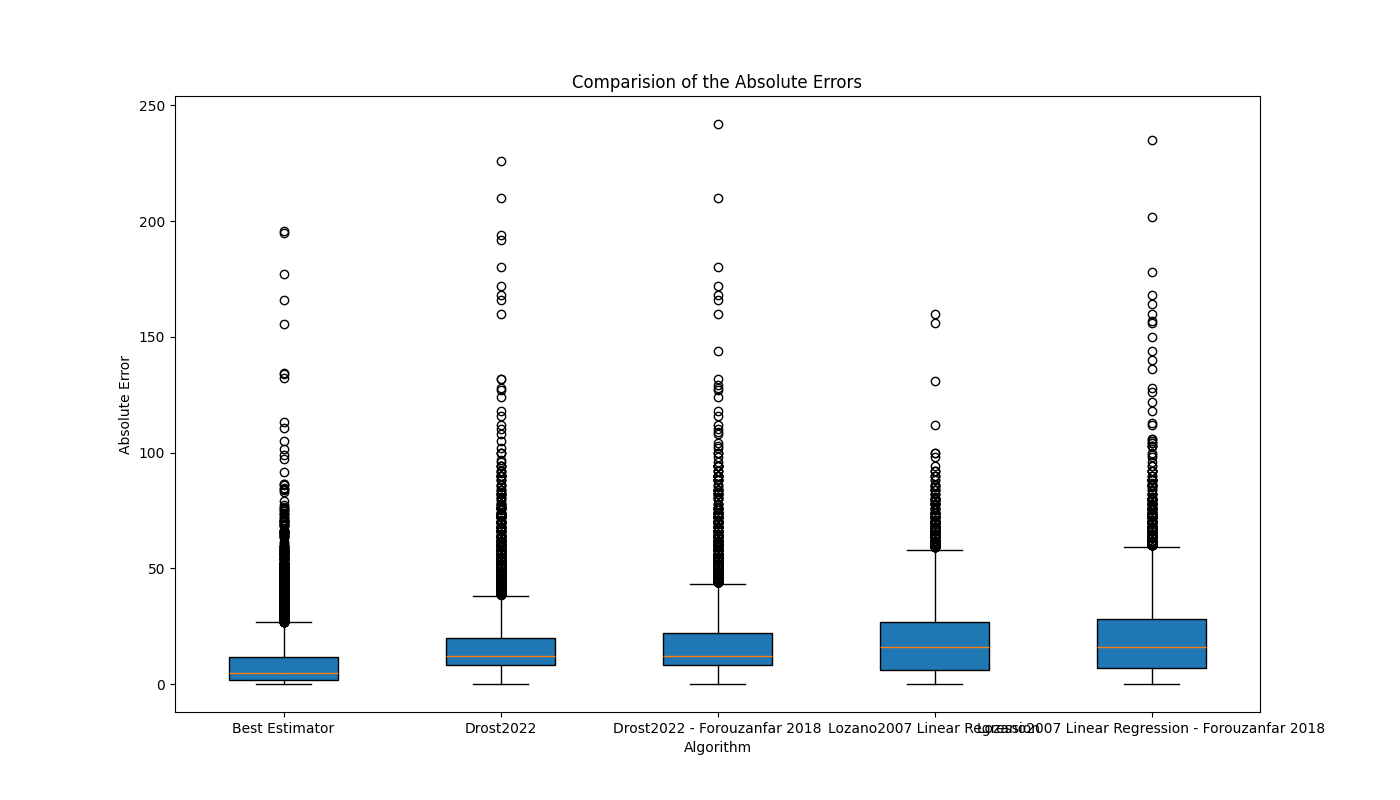

In [53]:
data = [abs_error_estimator, abs_error_empkins["drost2022_none"], abs_error_empkins["drost2022_forouzanfar2018"], abs_error_guardian["lozano2007-linear-regression_none"], abs_error_guardian["lozano2007-linear-regression_forouzanfar2018"]]
labels = ["Best Estimator", "Drost2022", "Drost2022 - Forouzanfar 2018", "Lozano2007 Linear Regression", "Lozano2007 Linear Regression - Forouzanfar 2018"]

plt.figure(figsize=(14, 8))
plt.boxplot(data, patch_artist=True, labels=labels)
plt.title("Comparision of the Absolute Errors")
plt.xlabel("Algorithm")
plt.ylabel("Absolute Error")
plt.show()